In [1]:
import sys
root_dir = '/home/gddaslab/mxp140/tcr_project_ultimate'
sys.path.append(root_dir)

import warnings
warnings.filterwarnings("ignore")

In [2]:
import tqdm
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from minimization import run_optimization

In [41]:
full_data = pd.read_csv('/home/gddaslab/mxp140/tcr_project_ultimate/data/BrMET_and_GBM_data-PANPEP.csv', sep=',')
max_kr = max(full_data['kr'].values)
patient_id ='BrMET009'
patient_data = full_data[full_data['Patient']==patient_id]
# Create a list of CDR3 sequences with repetition according to their counts
cdr3_list = []
for index, row in patient_data.iterrows():
    cdr3_list.extend([row['CDR3']] * row['counts'])
parameters_df = pd.read_excel('/home/gddaslab/mxp140/tcr_project_ultimate/results/results.xlsx', engine='openpyxl', sheet_name='parameters')

[POLITIS METHOD](https://normaldeviate.wordpress.com/2013/01/27/bootstrapping-and-subsampling-part-ii/)

In [45]:
# Calculate the total number of samples needed
n = patient_data['counts'].sum()
b = 1000
N = min(1000, math.comb(n, b))
print(f'{N} subsamples of size {b} created.')

all_sub_samples = []
sub_samples_to_save = pd.DataFrame(columns=[f'sample{i+1}' for i in range(N)])
for i in tqdm.tqdm(range(N)):
    sub_samples = np.random.choice(cdr3_list, size=b, replace=False)
    all_sub_samples.append(sub_samples)
    sub_samples_to_save[f'sample{i+1}'] = sub_samples
filename = f'/home/gddaslab/mxp140/tcr_project_ultimate/results/{patient_id}_bootstrapped_samples.csv.gz'
sub_samples_to_save.to_csv(filename, compression='gzip', sep=',', index=False)
print(f'Samples saved as {filename}.')

1000 subsamples of size 1000 created.


100%|██████████| 1000/1000 [00:20<00:00, 49.72it/s]


Samples saved as /home/gddaslab/mxp140/tcr_project_ultimate/results/BrMET009_bootstrapped_samples.csv.gz.


Confidence Interval: (np.float64(3.5690568887948126), np.float64(3.5690568887948126))


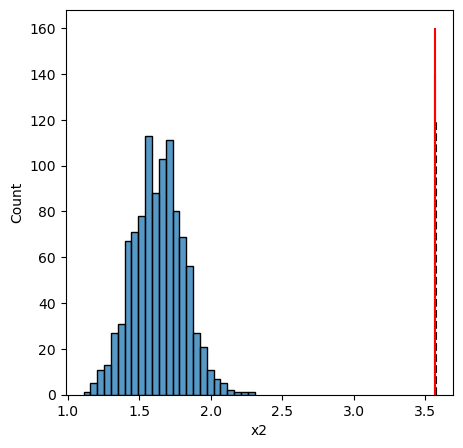

In [44]:
results = pd.read_csv(f'/home/gddaslab/mxp140/tcr_project_ultimate/results/{patient_id}_multiple_optimizations_from_bootstrapped_samples.csv', sep=',')
t_values = np.linspace(-3, 3, 1000)
theta_hat_b = results['x2'].values
theta_hat_n = parameters_df[(parameters_df['Patient']==patient_id) & (parameters_df['Region']=='combined')]['x2_panpep'].values[0]
L_n = [np.mean(np.sqrt(b) * (theta_hat_b - theta_hat_n) <= t) for t in t_values]
alpha = 0.5
# Step 5: Find the quantiles
t_alpha_2 = np.quantile(L_n, alpha/2)
t_1_alpha_2 = np.quantile(L_n, 1-(alpha/2))

# Step 6: Define the confidence interval
confidence_interval = (
    theta_hat_n - t_1_alpha_2 / np.sqrt(n),
    theta_hat_n - t_alpha_2 / np.sqrt(n)
)

print("Confidence Interval:", confidence_interval)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(data=results, x='x2')
ax.vlines(x=theta_hat_n, ymin=0, ymax=np.max(ax.get_yticks()), color='black', linestyle = 'dashed')
ax.vlines(x=confidence_interval[0], ymin=0, ymax=np.max(ax.get_yticks()), color='red')
ax.vlines(x=confidence_interval[1], ymin=0, ymax=np.max(ax.get_yticks()), color='red')
plt.show()